## Artigo Original: https://arxiv.org/abs/1505.03873

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
%cd drive/MyDrive

/content/drive/MyDrive


In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

In [3]:
import torch
import torch.nn as nn
import numpy as np

class GridLookupSpatialRelationPositionEncoder(nn.Module):

    def __init__(self, extent, interval=0.01, device='cuda'):

        super().__init__()
        self.x_min, self.x_max, self.y_min, self.y_max = extent
        self.interval = interval
        self.device = device

        self.num_cols = int(np.ceil((self.x_max - self.x_min) / self.interval)) + 1
        self.num_rows = int(np.ceil((self.y_max - self.y_min) / self.interval)) + 1

        self.num_cells = self.num_cols * self.num_rows

        print(f"Grid Config: {self.num_rows}x{self.num_cols} cells. Total IDs: {self.num_cells}")

    def forward(self, coords):
        lat = coords[..., 0]
        lon = coords[..., 1]

        col = torch.floor((lon - self.x_min) / self.interval).long()
        row = torch.floor((lat - self.y_min) / self.interval).long()

        col = torch.clamp(col, 0, self.num_cols - 1)
        row = torch.clamp(row, 0, self.num_rows - 1)

        index = row * self.num_cols + col

        return index

class GridLookupSpatialRelationLocationEncoder(nn.Module):
    def __init__(
        self,
        spa_embed_dim,
        extent,
        interval=0.1,
        coord_dim=2,
        device="cuda",
        ffn_act="relu",
        ffn_num_hidden_layers=1,
        ffn_dropout_rate=0.5,
        ffn_hidden_dim=256,
        ffn_use_layernormalize=True,
        ffn_skip_connection=True
    ):
        super().__init__()
        self.device = device

        self.position_encoder = GridLookupSpatialRelationPositionEncoder(
            extent=extent,
            interval=interval,
            device=device
        )

        self.lookup_embed = nn.Embedding(
            num_embeddings=self.position_encoder.num_cells,
            embedding_dim=ffn_hidden_dim
        )

        self.ffn = MultiLayerFeedForwardNN(
            input_dim=ffn_hidden_dim,
            output_dim=spa_embed_dim,
            num_hidden_layers=ffn_num_hidden_layers,
            dropout_rate=ffn_dropout_rate,
            hidden_dim=ffn_hidden_dim,
            activation=ffn_act,
            use_layernormalize=ffn_use_layernormalize,
            skip_connection=ffn_skip_connection,
            context_str="GridLookupEncoder"
        )

    def forward(self, coords):
        cell_ids = self.position_encoder(coords)

        embeds = self.lookup_embed(cell_ids)

        out = self.ffn(embeds)

        return out

In [9]:
import numpy as np
import torch

def get_auto_extent(coords):
    """
    Calcula (min_lon, max_lon, min_lat, max_lat) automaticamente baseando-se nos dados.

    Args:
        coords: Pode ser um DataFrame pandas (com colunas 'latitude', 'longitude')
                ou um Tensor/Numpy array shape [N, 2].
    """

    if hasattr(coords, 'columns'):
        lat = coords['latitude'].values
        lon = coords['longitude'].values

    else:
        if torch.is_tensor(coords):
            coords = coords.cpu().numpy()
        lat = coords[:, 0]
        lon = coords[:, 1]

    min_lat, max_lat = lat.min(), lat.max()
    min_lon, max_lon = lon.min(), lon.max()

    extent = (
        min_lon,
        max_lon,
        min_lat,
        max_lat
    )

    print(f"Extent calculado automaticamente: {extent}")
    print(f"Lat range: [{min_lat:.4f}, {max_lat:.4f}]")
    print(f"Lon range: [{min_lon:.4f}, {max_lon:.4f}]")

    return extent

In [10]:
ESTADO = "Alaska"

In [11]:
import pandas as pd

checkins = pd.read_csv(f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv')[['latitude', 'longitude', 'category','placeid']]
coords = np.stack([checkins['latitude'], checkins['longitude']], axis=1)
extensao = get_auto_extent(checkins)
categories = checkins[['category']].values
placeid = checkins[['placeid']].values

Extent calculado automaticamente: (np.float64(-166.52488052), np.float64(-131.596179076), np.float64(53.90404832), np.float64(70.398585))
Lat range: [53.9040, 70.3986]
Lon range: [-166.5249, -131.5962]


In [12]:
class TangLocationContrastiveModel(nn.Module):
    def __init__(self, embed_dim=64, extent=None, interval=0.1):
        super().__init__()

        self.encoder = GridLookupSpatialRelationLocationEncoder(
            spa_embed_dim=128,
            extent=extent,
            interval=interval,
            ffn_hidden_dim=256,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        self.projector = nn.Linear(128, embed_dim)

    def forward(self, coords):
        coords = coords.unsqueeze(1)
        z = self.encoder(coords)
        z = z[:, 0, :]
        z = self.projector(z)
        return torch.nn.functional.normalize(z, dim=-1)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ContrastiveSpatialDataset(Dataset):
    def __init__(self, coords, pos_radius=0.01):
        """
        Args:
            coords: Array numpy ou Tensor [N, 2] com todas as coordenadas (Lat, Lon).
            pos_radius: Raio (em graus) para considerar um ponto como "vizinho" (positivo).
                        0.01 graus é aprox 1.1km.
        """
        self.coords = coords
        self.num_points = len(coords)
        self.pos_radius = pos_radius

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):
        coord_i = self.coords[idx]

        if np.random.random() > 0.5:
            label = 1.0

            noise = np.random.normal(0, self.pos_radius, size=2)
            coord_j = coord_i + noise

        else:
            label = 0.0

            rand_idx = np.random.randint(0, self.num_points)
            coord_j = self.coords[rand_idx]

        return (
            torch.tensor(coord_i, dtype=torch.float32),
            torch.tensor(coord_j, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [15]:
def get_adaptive_interval(extent, target_divisions=200):
    """
    Calcula o tamanho da célula (interval) para que o mapa tenha
    aproximadamente 'target_divisions' no seu lado maior.

    Args:
        extent: (min_lon, max_lon, min_lat, max_lat)
        target_divisions: Quantas células queremos cabendo no mapa (Ex: 200).
                          Tang et al. usaram aprox 200 para os EUA.
    """
    min_lon, max_lon, min_lat, max_lat = extent

    width = max_lon - min_lon
    height = max_lat - min_lat

    max_dim = max(width, height)

    interval = max_dim / target_divisions

    km_size = interval * 111

    print(f"Dimensão do Mapa: {width:.2f}° x {height:.2f}°")
    print(f"Divisões Alvo: {target_divisions}")
    print(f"Intervalo Calculado: {interval:.5f} graus")
    print(f"Tamanho Físico Aprox: {km_size:.2f} km por célula")

    return interval

In [16]:
adaptive_interval = get_adaptive_interval(extensao, target_divisions=200)

Dimensão do Mapa: 34.93° x 16.49°
Divisões Alvo: 200
Intervalo Calculado: 0.17464 graus
Tamanho Físico Aprox: 19.39 km por célula


In [17]:
dataset = ContrastiveSpatialDataset(coords, pos_radius=0.01)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print(f"Total de batches por época: {len(loader)}")

sample_i, sample_j, sample_lbl = next(iter(loader))
print("\nExemplo de saída do Loader:")
print(f"Coord A (Shape): {sample_i.shape}")
print(f"Coord B (Shape): {sample_j.shape}")
print(f"Labels (Exemplo): {sample_lbl[:5]}")

Total de batches por época: 425

Exemplo de saída do Loader:
Coord A (Shape): torch.Size([64, 2])
Coord B (Shape): torch.Size([64, 2])
Labels (Exemplo): tensor([1., 1., 1., 1., 0.])


In [18]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [19]:
!pip install "sympy==1.12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 33.3 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cpu requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [20]:
model = TangLocationContrastiveModel(
    embed_dim=64,
    extent=extensao,
    interval=adaptive_interval
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def contrastive_bce(z_i, z_j, label, tau=0.1):
    sim = F.cosine_similarity(z_i, z_j)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)


for epoch in range(50):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for coord_i, coord_j, label in loader:

        ci = coord_i.float().to(device)
        cj = coord_j.float().to(device)

        z_i = model(ci)
        z_j = model(cj)

        loss = contrastive_bce(z_i, z_j, label, tau=0.15)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(n_batches, 1)
    print(f"Epoch {epoch+1:02d}: Loss = {avg_loss:.4f}")



Grid Config: 96x201 cells. Total IDs: 19296
Epoch 01: Loss = 0.6253
Epoch 02: Loss = 0.6018
Epoch 03: Loss = 0.5970
Epoch 04: Loss = 0.5846
Epoch 05: Loss = 0.5798
Epoch 06: Loss = 0.5771
Epoch 07: Loss = 0.5862
Epoch 08: Loss = 0.5775
Epoch 09: Loss = 0.5765
Epoch 10: Loss = 0.5813
Epoch 11: Loss = 0.5738
Epoch 12: Loss = 0.5797
Epoch 13: Loss = 0.5654
Epoch 14: Loss = 0.5705
Epoch 15: Loss = 0.5736
Epoch 16: Loss = 0.5679
Epoch 17: Loss = 0.5661
Epoch 18: Loss = 0.5760
Epoch 19: Loss = 0.5671
Epoch 20: Loss = 0.5683
Epoch 21: Loss = 0.5685
Epoch 22: Loss = 0.5709
Epoch 23: Loss = 0.5734
Epoch 24: Loss = 0.5705
Epoch 25: Loss = 0.5751
Epoch 26: Loss = 0.5657
Epoch 27: Loss = 0.5662
Epoch 28: Loss = 0.5664
Epoch 29: Loss = 0.5650
Epoch 30: Loss = 0.5610
Epoch 31: Loss = 0.5703
Epoch 32: Loss = 0.5613
Epoch 33: Loss = 0.5640
Epoch 34: Loss = 0.5599
Epoch 35: Loss = 0.5616
Epoch 36: Loss = 0.5680
Epoch 37: Loss = 0.5658
Epoch 38: Loss = 0.5682
Epoch 39: Loss = 0.5604
Epoch 40: Loss = 0.5

In [21]:
loc_embeds = model(torch.Tensor(coords))

loc_embeds

tensor([[ 0.0526, -0.0890,  0.0637,  ..., -0.1287, -0.0732, -0.2024],
        [ 0.0047, -0.1386,  0.1922,  ...,  0.0052, -0.0383, -0.1574],
        [ 0.0488, -0.2085,  0.1092,  ..., -0.0445, -0.0439, -0.1575],
        ...,
        [ 0.1204,  0.0259,  0.1065,  ...,  0.1966, -0.0247,  0.1827],
        [ 0.0764,  0.0795,  0.2762,  ...,  0.1309, -0.0245, -0.0319],
        [ 0.1123,  0.0761,  0.0839,  ...,  0.0152, -0.1230,  0.0373]],
       grad_fn=<DivBackward0>)

In [22]:
loc_embeds = loc_embeds.detach().numpy()

In [24]:
import pandas as pd
import numpy as np
import torch
import os
folder_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/tile/"
if not os.path.exists(folder_path):
  os.makedirs(folder_path)

emb_np = loc_embeds
n_embeds = emb_np.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

placeid_arr   = np.asarray(placeid).reshape(-1)
category_arr  = np.asarray(categories).reshape(-1)

if emb_np.shape[0] != len(placeid_arr):
    raise ValueError(f"loc_embeds tem {emb_np.shape[0]} linhas, "
                     f"mas placeid tem {len(placeid_arr)} elementos.")

df_location_embeddings = pd.DataFrame(emb_np, columns=embed_cols)
df_location_embeddings.insert(0, "placeid", placeid_arr.astype(str))
df_location_embeddings["category"] = category_arr.astype(str)

print("df_location_embeddings (check-in level):", df_location_embeddings.shape)

df_mean_embeds = (
    df_location_embeddings
    .groupby("placeid")[embed_cols]
    .mean()
    .reset_index()
)

df_mode_cat = (
    df_location_embeddings
    .groupby("placeid")["category"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .reset_index()
)

df_final = df_mean_embeds.merge(df_mode_cat, on="placeid")

print("df_final (POI-level):", df_final.shape)

out_path = f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/tile/location_encoder_embeddings-{ESTADO.lower()}.csv"
df_final.to_csv(out_path, index=False)
df_final.head()


df_location_embeddings (check-in level): (27258, 66)
df_final (POI-level): (2740, 66)


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,1000487,-0.081625,0.120415,-0.106649,-0.100636,-0.057398,-0.193837,-0.183948,-0.092552,0.088844,...,-0.184707,-0.029878,-0.004483,-0.013940,-0.024459,-0.033492,-0.043583,0.046330,0.164825,Shopping
1,1001578,-0.188059,0.010460,-0.194790,0.142002,0.041148,-0.167816,0.051983,0.042348,0.197525,...,0.059365,0.100289,-0.082590,-0.096138,-0.052495,-0.087248,0.129788,0.010471,-0.114815,Food
2,1008534,-0.067243,0.068202,-0.093678,0.129404,0.050965,0.105921,0.150607,0.058369,-0.016417,...,0.108567,0.133533,-0.101133,0.026578,-0.098029,0.026232,-0.084204,0.018371,-0.000374,Entertainment
3,1008890,-0.031554,-0.050312,0.069242,-0.031523,0.095811,0.195704,0.023175,0.033187,-0.042249,...,0.222153,0.001287,-0.044139,-0.005858,0.003624,0.006337,-0.048364,0.054399,-0.041800,Shopping
4,1010345,0.228804,0.136202,0.156460,0.089288,-0.280839,-0.186941,-0.093577,0.088375,0.004279,...,-0.124086,-0.127310,0.117195,-0.098539,-0.146611,-0.070425,-0.024327,0.000515,-0.000014,Community


In [25]:
df = pd.read_csv(f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/tile/location_encoder_embeddings-{ESTADO.lower()}.csv")
placeids = df["placeid"].astype(str).tolist()
E = df[[c for c in df.columns if c.isnumeric()]].to_numpy(dtype=np.float32)

torch.save({
    "embeddings": torch.from_numpy(E),
    "placeids": placeids
}, f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/tile/poi_embeddings_location-{ESTADO.lower()}.pt")


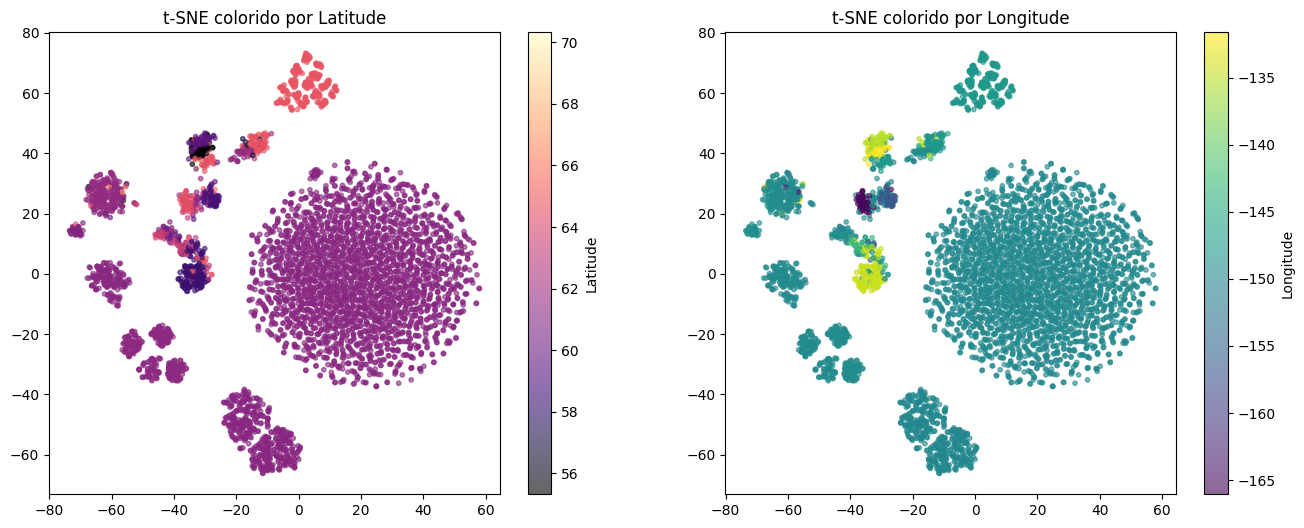

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

n_samples = 5000
indices = np.random.choice(len(loc_embeds), n_samples, replace=False)

subset_embeds = loc_embeds[indices]
subset_coords = coords[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(subset_embeds)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sc1 = ax[0].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 0], cmap='magma', s=10, alpha=0.6)
ax[0].set_title("t-SNE colorido por Latitude")
plt.colorbar(sc1, ax=ax[0], label='Latitude')

sc2 = ax[1].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 1], cmap='viridis', s=10, alpha=0.6)
ax[1].set_title("t-SNE colorido por Longitude")
plt.colorbar(sc2, ax=ax[1], label='Longitude')

plt.show()